In [12]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [39]:
retail = pd.read_csv('OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [14]:
cols = ["Quantity","UnitPrice","Country","CustomerID"]
retail[cols].nunique()

Quantity       722
UnitPrice     1630
Country         38
CustomerID    4372
dtype: int64

In [40]:
retail.dropna(subset = "CustomerID",inplace = True)
retail["Amount"] = retail["Quantity"]*retail["UnitPrice"]
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [41]:
rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [18]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
 8   amount       406829 non-null  float64
 9   Amount       406829 non-null  float64
dtypes: float64(4), int64(1), object(5)
memory usage: 34.1+ MB


In [42]:
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')
retail['InvoiceDate']

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541904   2011-12-09 12:50:00
541905   2011-12-09 12:50:00
541906   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 406829, dtype: datetime64[ns]

In [43]:
date_max = retail.groupby('CustomerID')['InvoiceDate'].max()
retail_new = pd.merge(retail,date_max,on='CustomerID',how = "inner")
retail_new

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate_x,UnitPrice,CustomerID,Country,Amount,InvoiceDate_y
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2011-02-10 14:38:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2011-02-10 14:38:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2011-02-10 14:38:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2011-02-10 14:38:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2011-02-10 14:38:00
...,...,...,...,...,...,...,...,...,...,...
406824,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011-12-09 12:50:00
406825,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011-12-09 12:50:00
406826,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-09 12:50:00
406827,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-09 12:50:00


In [44]:
retail_new["Recency"] = (retail_new["InvoiceDate_y"]-retail_new["InvoiceDate_x"]).dt.days
retail_new

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate_x,UnitPrice,CustomerID,Country,Amount,InvoiceDate_y,Recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2011-02-10 14:38:00,71
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2011-02-10 14:38:00,71
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2011-02-10 14:38:00,71
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2011-02-10 14:38:00,71
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2011-02-10 14:38:00,71
...,...,...,...,...,...,...,...,...,...,...,...
406824,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011-12-09 12:50:00,0
406825,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011-12-09 12:50:00,0
406826,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-09 12:50:00,0
406827,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-09 12:50:00,0


In [45]:
retail_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406829 entries, 0 to 406828
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   InvoiceNo      406829 non-null  object        
 1   StockCode      406829 non-null  object        
 2   Description    406829 non-null  object        
 3   Quantity       406829 non-null  int64         
 4   InvoiceDate_x  406829 non-null  datetime64[ns]
 5   UnitPrice      406829 non-null  float64       
 6   CustomerID     406829 non-null  float64       
 7   Country        406829 non-null  object        
 8   Amount         406829 non-null  float64       
 9   InvoiceDate_y  406829 non-null  datetime64[ns]
 10  Recency        406829 non-null  int64         
dtypes: datetime64[ns](2), float64(3), int64(2), object(4)
memory usage: 34.1+ MB


In [51]:
rfm_r = retail_new[retail_new["Recency"]>0].groupby("CustomerID")["Recency"].min()
rfm_r = rfm_r.reset_index()
rfm_r.head()

,CustomerID,Recency
0,12347.0,37
1,12348.0,173
2,12352.0,35
3,12356.0,222
4,12358.0,149


In [52]:
rfm = pd.merge(rfm_m,rfm_f,on=['CustomerID'],how = "inner")
rfm  = pd.merge(rfm,rfm_r,on=['CustomerID'],how = "inner")
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12347.0,4310.00,182,37
1,12348.0,1797.24,31,173
2,12352.0,1545.41,95,35
3,12356.0,2811.43,59,222
4,12358.0,1168.06,19,149


In [62]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2980 entries, 0 to 2979
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  2980 non-null   float64
 1   Amount      2980 non-null   float64
 2   Frequency   2980 non-null   int64  
 3   Recency     2980 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 93.3 KB


Text(0.5, 0, 'Attributes')

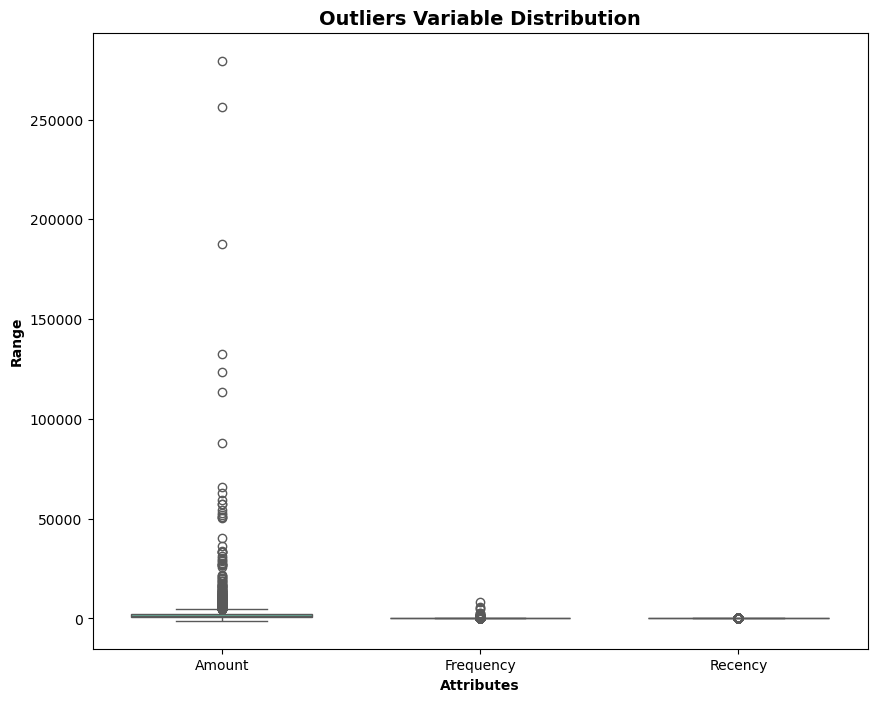

In [54]:
attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

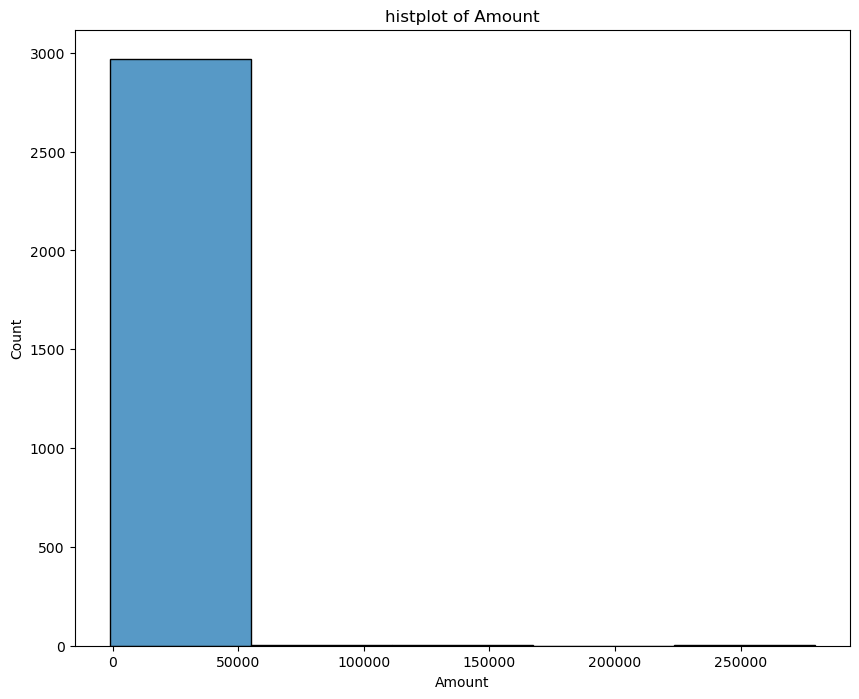

In [60]:
fig= plt.figsize=(20,20)
sns.histplot(data = rfm,x = "Amount",bins = 5)
plt.title("histplot of Amount")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.show()

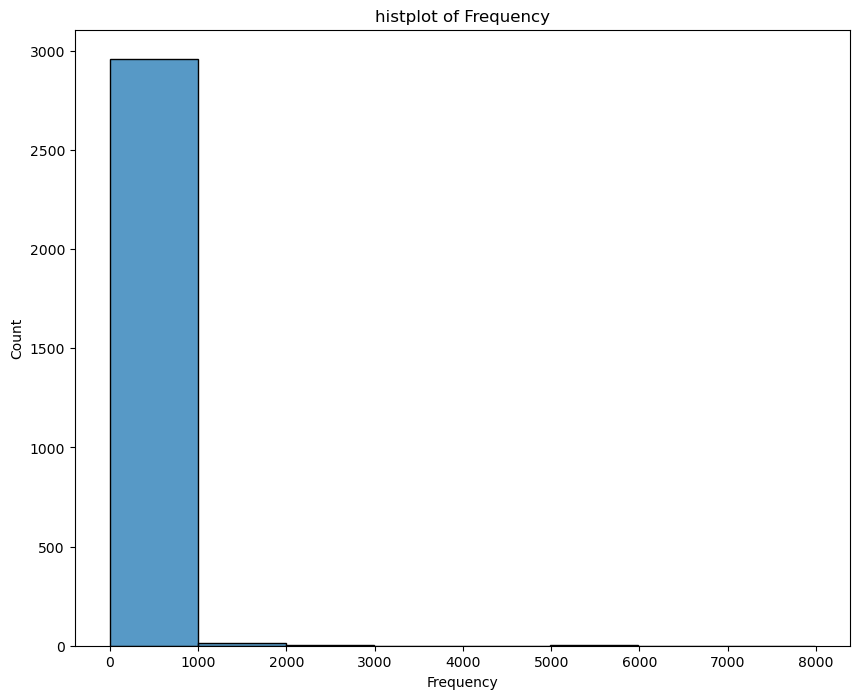

In [57]:
fig= plt.figsize=(20,20)
sns.histplot(data = rfm,x = "Frequency",bins = 8)
plt.title("histplot of Frequency")
plt.xlabel("Frequency")
plt.ylabel("Count")
plt.show()

In [80]:
normal_data = rfm[(rfm["Frequency"]<=1000)&(rfm["Amount"]<=50000)]
normal_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2948 entries, 0 to 2979
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  2948 non-null   float64
 1   Amount      2948 non-null   float64
 2   Frequency   2948 non-null   int64  
 3   Recency     2948 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 115.2 KB


In [81]:
normal_data = normal_data[["Amount","Frequency","Recency"]]
scaler = StandardScaler()
# fit_transform
normal_data = scaler.fit_transform(normal_data)
normal_data = pd.DataFrame(normal_data,columns = ["Amount","Frequency","Recency"])
normal_data.head()

,Amount,Frequency,Recency
0,0.762195,0.594400,-0.382305
1,-0.059144,-0.629658,1.464402
2,-0.141459,-0.110852,-0.409462
3,0.272361,-0.402680,2.129759
4,-0.264803,-0.726934,1.138512


In [82]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(normal_data)
type = kmeans.labels_
type 

array([2, 0, 2, ..., 0, 1, 2])

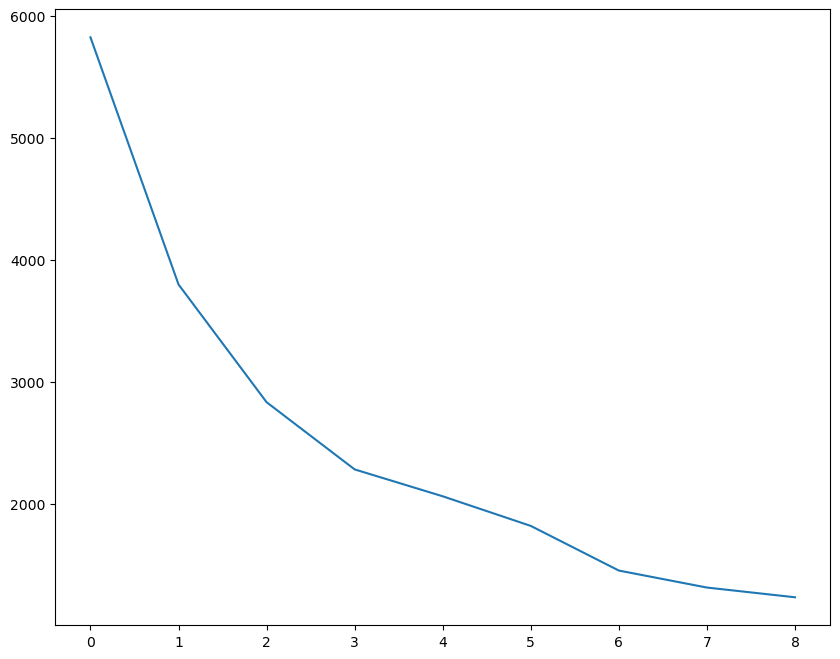

In [83]:
ssd = []
range_n_clusters = [i for i in range(2,11)]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(normal_data)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

In [84]:
range_n_clusters = [i for i in range(2,11)]
for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(normal_data)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(normal_data, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5539971762425316
For n_clusters=3, the silhouette score is 0.4570449647945705
For n_clusters=4, the silhouette score is 0.503251313365695
For n_clusters=5, the silhouette score is 0.40141207446681043
For n_clusters=6, the silhouette score is 0.41538955463602084
For n_clusters=7, the silhouette score is 0.420002899619093
For n_clusters=8, the silhouette score is 0.3606539518556737
For n_clusters=9, the silhouette score is 0.3617984368756939
For n_clusters=10, the silhouette score is 0.37108968227143263


In [85]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(normal_data)
kmeans.labels_


array([3, 2, 0, ..., 0, 3, 0])

In [86]:
normal_data["type"]= kmeans.labels_
normal_data.head()

,Amount,Frequency,Recency,type
0,0.762195,0.594400,-0.382305,3
1,-0.059144,-0.629658,1.464402,2
2,-0.141459,-0.110852,-0.409462,0
3,0.272361,-0.402680,2.129759,2
4,-0.264803,-0.726934,1.138512,2


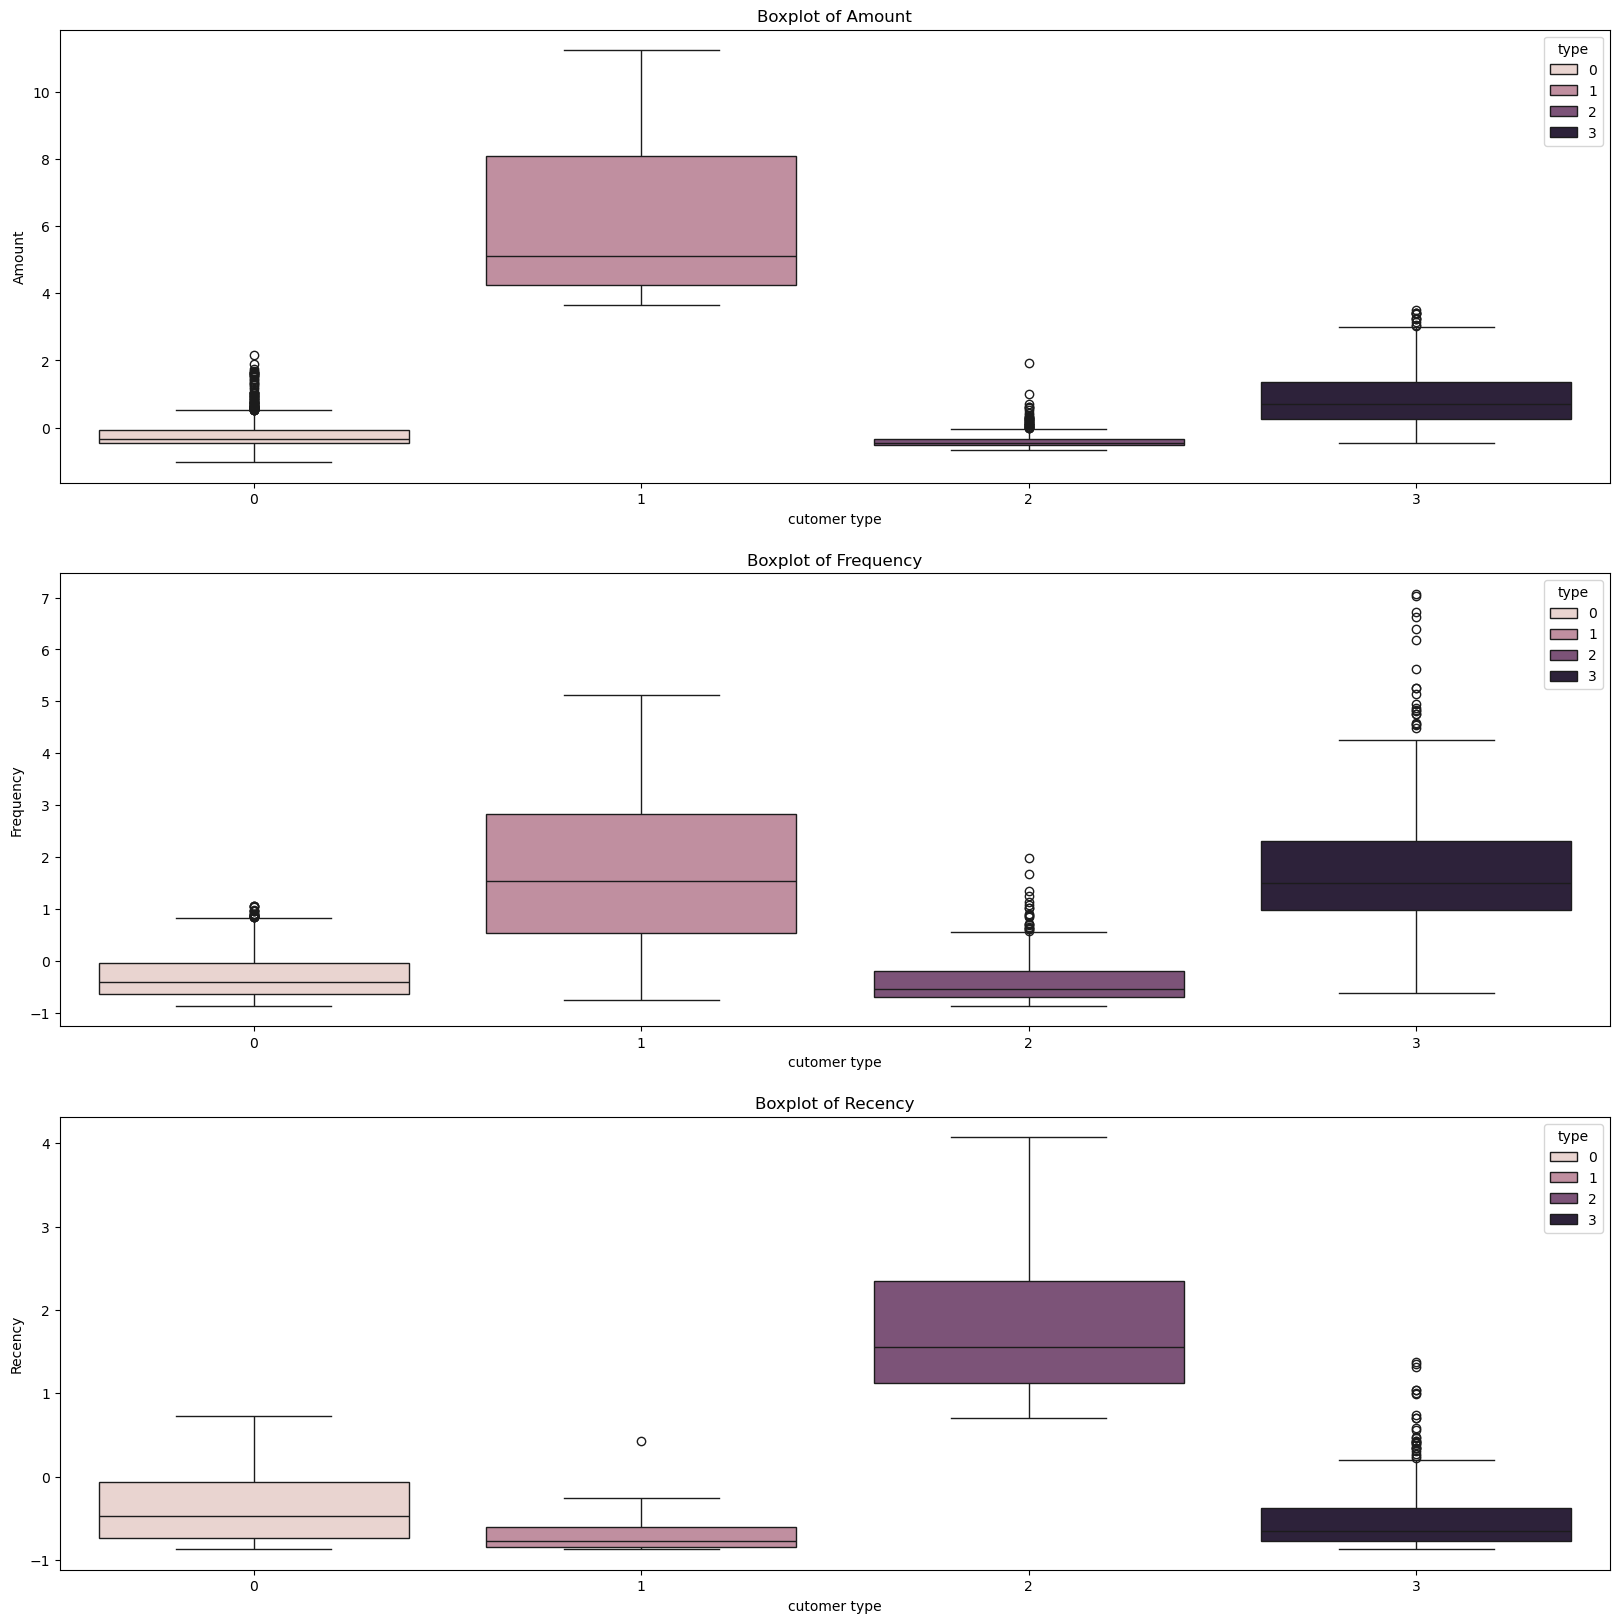

In [93]:
fig,axs = plt.subplots(3,1,figsize =(20,20))
for feature,ax in zip(["Amount","Frequency","Recency"], axs.ravel()):
    sns.boxplot(x='type', y=feature, data=normal_data,ax = ax, hue ="type" )
    ax.set_title(f"Boxplot of {feature}")
    ax.set_xlabel("cutomer type")